# Relationship Networks with CIFAR-100

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf

import load_cifar

%matplotlib inline
from IPython.core.pylabtools import figsize
from IPython import display
import matplotlib.pyplot as plt

## Load in the dataset and take a gander

In [2]:
(train_images, test_images), (train_labels, test_labels) = load_cifar.Batches(
    dataset="cifar100",
    include_labels=True)

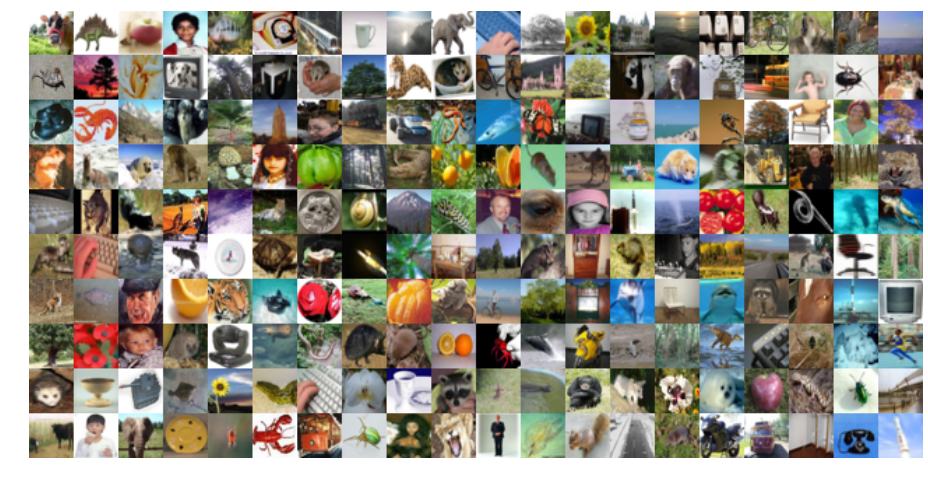

In [3]:
figsize(16, 8)
plt.imshow(
    np.concatenate(
        [np.concatenate(list(train_images[i * 20:(i + 1) * 20]), axis=1)
         for i in xrange(10)]))
plt.axis("off")
plt.show()

In [4]:
train_labels_one_hot = np.zeros((50000, 100))
train_labels_one_hot[np.arange(50000), train_labels] = 1
test_labels_one_hot = np.zeros((10000, 100))
test_labels_one_hot[np.arange(10000), test_labels] = 1

In [6]:
class counter(object):
    
    _COUNTER = 0
    
    @classmethod
    def inc(cls):
        next_id = cls._COUNTER
        cls._COUNTER += 1
        return next_id

## Train a Classification Net
### Utilities

In [67]:
# The Scaled Exponential Linear Unit guarantees an
# approximately normally distributed output, if inputs
# are also approximately normally distributed.
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * tf.where(
        x >= 0.0,
        x,
        (alpha * tf.exp(x)) - alpha)


# Mirror padding (instead of the 0-padding that most
# libararies use by default) ensures inputs won't have
# wonky 0-filled distributions.
def mirror_padding(im, n):
    _, height, width, _ = im.get_shape().as_list()
    im = tf.concat(
        [tf.reverse(im[:, :n, :, :], [1]),
         im,
         tf.reverse(im[:, height - n:, :, :], [1])],
        1)
    im = tf.concat(
        [tf.reverse(im[:, :, :n, :], [2]),
         im,
         tf.reverse(im[:, :, height - n:, :], [2])],
        2)
    return im


def conv(net, channels, kernel_size):
    return tf.layers.conv2d(
        mirror_padding(net, kernel_size / 2),
        channels,
        kernel_size,
        padding="VALID",
        activation=selu)


def image_to_pixel_pairs(im):
    _, height, width, _ = im.get_shape().as_list()
    pixels = []
    for h in np.arange(height):
        for w in np.arange(width):
            pixels.append(
                tf.concat(
                    [im[:, h, w, :],
                     (tf.ones_like(im[:, 1, 1, :1], dtype=tf.float32) * h) / height,
                     (tf.ones_like(im[:, 1, 1, :1], dtype=tf.float32) * w) / width],
                axis=-1))
    pairs = []
    for i in np.arange(len(pixels)):
        for j in np.arange(len(pixels)):
            if i != j:
                pairs.append(tf.expand_dims(tf.concat([pixels[i], pixels[j]], 1), 1))
    return tf.concat(pairs, 1)
    

def relation(pairs, g_sizes, f_sizes, training):
    for g_hidden in g_sizes:
        pairs = tf.layers.conv1d(pairs, g_hidden, 1, activation=selu)
    rels = tf.reduce_mean(pairs, axis=1)
    for i, f_hidden in enumerate(f_sizes):
        act = None if i == len(f_sizes) - 1 else selu
        rels = tf.layers.dense(rels, f_hidden, activation=act)
        if i == len(f_sizes) - 2:
            rels = tf.layers.dropout(rels, training=training)
    return rels


def downsample_conv_block(net, ch):
    net = tf.contrib.layers.max_pool2d(net, 2)
    net = conv(net, ch, 3)
    net = conv(net, ch, 3)
    return net

### Architecture

In [81]:
def final_rn(g_sizes=[64, 64, 64], f_sizes=[128, 128, 100]):
    def add_rn(net, is_train):
        net = image_to_pixel_pairs(net)
        net = relation(net, g_sizes, f_sizes, is_train)
        return net
    return add_rn


class RelationModel(object):
    
    def __init__(
            self,
            input_shape=[32, 32, 3],
            n_class=100,
            logits_fn=final_rn(),
            pattern=[32, 32, 64, 128],
            block_fn=downsample_conv_block):
        self._id = counter.inc()
        self._sess = tf.get_default_session() or tf.InteractiveSession()
        self._input_shape = input_shape
        self._n_class = n_class
        self._logits_fn = logits_fn
        self._pattern = pattern
        self._block_fn = block_fn

        self._whitening_fit = False
        self._inp_mean = 0.0
        self._inp_sd = 1.0
        
        self._losses = []
        self._accs = []
        
        self._inp = None
        self._whiten_mean = None
        self._whiten_sd = None
        self._outp = None
        self._targets = None
        self._xent = None
        self._acc = None
        self._train_step = None
        self._is_train = None
        self._lr = None
        with tf.variable_scope("RelationModel{}".format(self._id)):
            self._build()
    
    def _build(self):
        # Placeholders for inputs and outupts
        self._inp = tf.placeholder(tf.float32, shape=[None] + self._input_shape)
        self._is_train = tf.placeholder(tf.bool, shape=[])
        self._targets = tf.placeholder(tf.float32, shape=[None, self._n_class])
        self._whiten_mean = tf.placeholder(tf.float32, shape=[])
        self._whiten_sd = tf.placeholder(tf.float32, shape=[])
        
        # Correct shape for rank 2 inputs
        if len(self._input_shape) == 2:
            net = tf.expand_dims(self._inp, -1)
        else:
            net = self._inp

        # Main architecture
        net = conv(
            (net - self._whiten_mean) / self._whiten_sd,
            self._pattern[0], 5)
        for ch in self._pattern[1:]:
            net = self._block_fn(net, ch)
        net = self._logits_fn(net, self._is_train)

        # Outputs and loss
        self._outp = tf.nn.softmax(net)
        self._xent = -tf.reduce_mean(self._targets * tf.log(self._outp))
        self._acc = tf.reduce_mean(tf.cast(
                tf.equal(
                    tf.argmax(self._targets, 1),
                    tf.argmax(self._outp, 1)),
                tf.float32))
        self._lr = tf.placeholder(tf.float32, shape=[])
        self._train_step = tf.train.AdamOptimizer(
            self._lr).minimize(self._xent)
        
        self._sess.run(tf.global_variables_initializer())

    def _fit_whitening(self, images, n=1000):
        if not self._whitening_fit:
            self._inp_mean = np.mean(images[:n])
            self._inp_sd = np.std(images[:n])
        
    def _text_report(self, b, n_batch):
        report = "<br>".join([
            "Batch {} of {} ({} total)".format(
                b + 1, n_batch, len(self._accs)),
            "Accuracy: {:.1f}%".format(np.mean(self._accs[-50:]) * 100),
            "Loss: {}".format(np.mean(self._losses[-50:]))])
        return display.HTML(report)
    
    def _graph_report(self):
        figsize(16, 4)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        batches = np.arange(len(self._accs))
        ax1.plot(batches, self._accs, alpha=0.2, color="green")
        ax1.plot(
            batches, pd.Series(self._accs).rolling(50).mean(),
            color="green")
        ax1.set_title("Accuracy by Batch")
        ax2.plot(batches, self._losses, alpha=0.2, color="blue")
        ax2.plot(
            batches, pd.Series(self._losses).rolling(50).mean(),
            color="blue")
        ax2.set_title("Loss by Batch")
        plt.close()
        return fig
        
    def _fit_batch(self, images, labels, lr):
        _, loss, acc = self._sess.run(
            [self._train_step, self._xent, self._acc],
            feed_dict={
                self._inp: images,
                self._whiten_mean: self._inp_mean,
                self._whiten_sd: self._inp_sd,
                self._targets: labels,
                self._lr: lr,
                self._is_train: True})
        self._losses.append(loss)
        self._accs.append(acc)
    
    def _fit_epoch(self, images, labels, batchsize, report_every, lr):
        n_batch = len(images) / batchsize
        ixs = np.arange(len(images))
        np.random.shuffle(ixs)
        for b in np.arange(n_batch):
            offset = b * batchsize
            batch_ixs = ixs[offset:offset + batchsize]
            self._fit_batch(images[batch_ixs], labels[batch_ixs], lr)
            
            if (b + 1) % report_every == 0:
                text = self._text_report(b, n_batch)
                fig = self._graph_report()
                display.clear_output(wait=True)
                display.display(fig, text)
        
    def fit(self, images, labels, n_epoch=1, batchsize=50, report_every=10, lr=0.001):
        self._fit_whitening(images)
        for ep in np.arange(n_epoch):
            self._fit_epoch(images, labels, batchsize, report_every, lr)
    
    def predict(self, images):
        return self._sess.run(
            [self._outp],
            feed_dict={
                self._inp: images,
                self._whiten_mean: self._inp_mean,
                self._whiten_sd: self._inp_sd,
                self._is_train: False})[0]
    

### Instantiate & Train

In [40]:
rm = RelationModel()

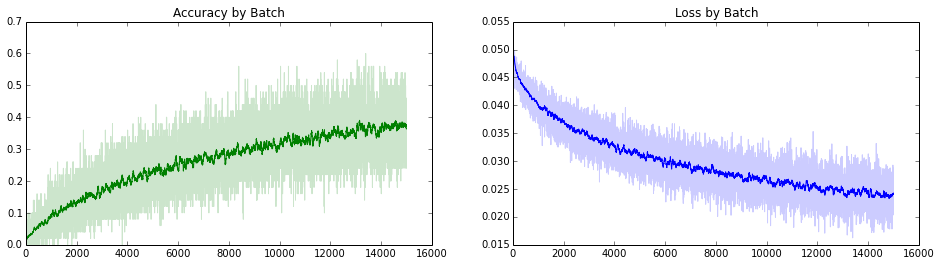

In [52]:
rm.fit(train_images, train_labels_one_hot, n_epoch=15, report_every=20, lr=0.0001)

In [54]:
preds = rm.predict(test_images)

In [62]:
test_acc = (preds.argmax(axis=1) == test_labels).mean()
print "Test Accuracy: {:.2f}%".format(test_acc * 100)

Test Accuracy: 37.68%
